## APPLIED DATA ANALYSIS - Course Project 

## Free Diving into Food Facts

In this notebook , I am trying to clean and prepare the dataset to answer the 4th question proposed in the readme  
**How do ingredients or categories influence the selected nutrition scores?** 

### Imports needed 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import re
import sqlite3
from datetime import datetime
%matplotlib inline

In [2]:
food_facts_df = pd.read_csv('data/en.openfoodfacts.org.products.csv', encoding='UTF-8', sep='\t',low_memory=False)

In [3]:
print('There are {:,} rows '.format(food_facts_df.shape[0]) + 'and {} columns in our data'.format(food_facts_df.shape[1]))


There are 1,029,403 rows and 175 columns in our data


In [4]:
food_facts_df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#lets fix the code as indes 
food_facts_df.set_index('code', inplace=True)

As we can see from the 5 first rows in the dataset, the data is messy and has a huge number of NaNs. Let's try first to deal with NaNs. 

Before dealing with NaNs and duplicates, let's try to see what are the different columns of the dataset 

In [6]:
food_facts_df.columns

Index(['url', 'creator', 'created_t', 'created_datetime', 'last_modified_t',
       'last_modified_datetime', 'product_name', 'generic_name', 'quantity',
       'packaging',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=174)

As we can see, each row of this dataset in created by an editor. This allows us to ask the following question:

### Can we trust Open Food Facts dataset?

The creators of each row of the dataset is provided as a field. Let's try to see who are the main contributors of this data before starting to analyse it.

In [7]:
nb_contributors=food_facts_df['creator'].unique().shape[0]
print("We have overall {} contributors".format(nb_contributors))

We have overall 9514 contributors


In [8]:
counts = food_facts_df['creator'].value_counts()
counts = counts.to_frame(name='counts')
counts['percentage'] = counts['counts']/food_facts_df.shape[0]

top_5 = round(sum(counts[0:5]['percentage']),2)*100
print("The 5 main", 'creators',"account for", top_5,"% of all contributions \n")
print(counts.head(5))

The 5 main creators account for 85.0 % of all contributions 

                            counts  percentage
kiliweb                     540501    0.525063
usda-ndb-import             169854    0.165002
openfoodfacts-contributors  116969    0.113628
date-limite-app              25145    0.024427
elcoco                       24830    0.024121


After googling these 5 main contributors we can easily identify them: 
* `kiliweb` represents the YUKA app that analyse the food products and recommand the best for our health. (French app)
* `usda` represnets United States Department of Agriculture 
* `openfoodfacts-contributors` a bench of 20 main contributors. We don't now a lot about them... 
* `data-limite-app` food application available for ios and androids users. (French app)
* `Elcoco` also a food application as YUKA. (spanish applcation)

Now let's get the normalized number of nans for the top5 contributors seperately and all the rest together :  
$NaNs_{normalized} = \frac{\sum NaNs}{\sum contributions}$ 

In [9]:
top5_cont=counts.head(5).index
nan_normalized_top5=np.zeros((5,1))
for index,contributor in enumerate(top5_cont):
    cont_df=food_facts_df.loc[food_facts_df['creator'] == contributor]
    nan_normalized_top5[index]=cont_df.isnull().sum().sum()/counts['counts'][index]
df_not5=food_facts_df.loc[~food_facts_df['creator'].isin([top5_cont[0],top5_cont[1],top5_cont[2],top5_cont[3],top5_cont[4]])]
nan_normalized_allrest=df_not5.isnull().sum().sum()/counts[6:]['counts'].sum()

In [10]:
for index,nan_normalized in enumerate(nan_normalized_top5): 
    print("Normalized number of nans for the contributor {} is {}".format(counts.index[index],nan_normalized[0]))
print ("Normalized number of nans for the rest of contributors is {}".format(nan_normalized_allrest))

Normalized number of nans for the contributor kiliweb is 142.13863249096673
Normalized number of nans for the contributor usda-ndb-import is 133.60365961355046
Normalized number of nans for the contributor openfoodfacts-contributors is 139.4291478938864
Normalized number of nans for the contributor date-limite-app is 146.52539272221117
Normalized number of nans for the contributor elcoco is 145.62138542086186
Normalized number of nans for the rest of contributors is 139.86990991247217


We clearly see that a huge number of NaNs are coming from the rest of contributors. we need then to take only the contributions of the top 5 creators. They are the most reliable and their contributions are considered as a verifiable resource. the rest isn't verifiable since the data comes from unkown creators. 

In [11]:
food_facts_df=food_facts_df.loc[food_facts_df['creator'].isin([top5_cont[0],top5_cont[1],top5_cont[2],top5_cont[3],top5_cont[4]])]

This dataset is provided with a text file describing the different fields as follows : 
- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
- fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product


This can help us to remove all the columns that do not correpond to ingeredients or nutrition score. We can see that all the nutrition facts columns end with "_100g"

We now know that all the ingredient fields end with '_100g'. For this part we want to know the impact of these ingredients on the nutrition score

In [12]:
cols_to_keep=[c for c in food_facts_df.columns if c.endswith("_100g")]

In [13]:
print("We have {} nutrition facts".format(len(cols_to_keep)))

We have 107 nutrition facts


In [14]:
nutrition_facts_df=food_facts_df[cols_to_keep] # we keep only ingredient columns
nutrition_facts_df.head()

,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
code,,,,,,,,,,,,,,,,,,,,,
0000000000017,1569.0,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000000001111111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000123,88.0,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000178,251.0,NaN,3.0,1.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print('There are {:,} rows '.format(nutrition_facts_df.shape[0]) + 'and {} columns left in our data'.format(nutrition_facts_df.shape[1]))

There are 877,299 rows and 107 columns left in our data



### Dealing with NaNs

Let's count the number of nans for each ingredient: 

In [16]:
NaNs_distribution_series=nutrition_facts_df.isnull().sum().sort_values()
NaNs_distribution_series

energy_100g                          163056
proteins_100g                        164272
fat_100g                             166174
carbohydrates_100g                   166306
sugars_100g                          175300
                                      ...  
-lignoceric-acid_100g                877299
-caproic-acid_100g                   877299
-melissic-acid_100g                  877299
-dihomo-gamma-linolenic-acid_100g    877299
-caprylic-acid_100g                  877299
Length: 107, dtype: int64

The previous pandas serie contains the distribution of NaNs between columns. Let's try to remove the columns where the number of NaNs exceeds a certain threshold. 

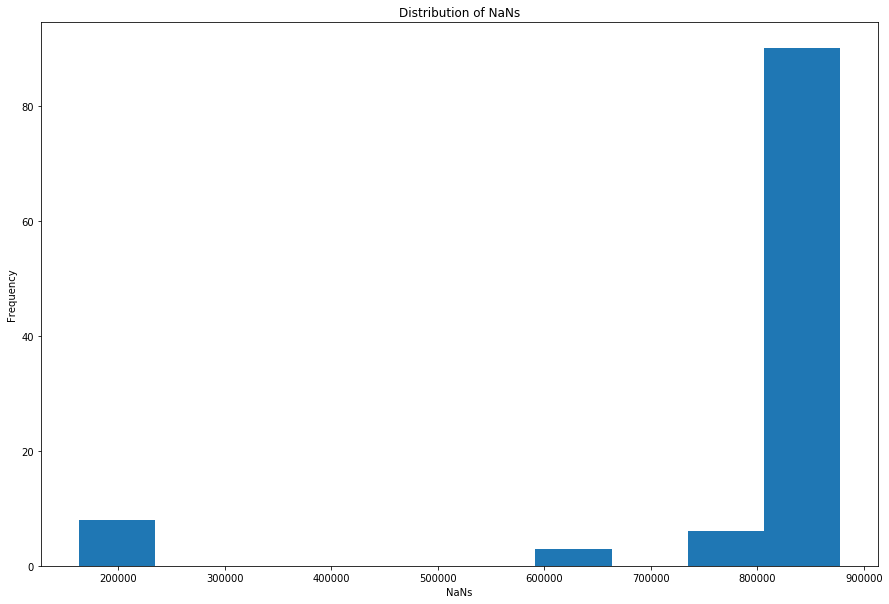

In [17]:
nutrition_facts_df.isnull().sum().plot(kind='hist', figsize=(15,10))
plt.title('Distribution of NaNs')
plt.xlabel('NaNs')

plt.show()

Many columns have huge number of NaNs (More then 85 fields with 1000000 NaNs), let's try to remove them by playing with the threshold value of the dropna function. We will plot afterwords the new distibution of NaNs. Our objective is to remove this huge peak of frequency visualized in the plot above. 

In [18]:
nutrition_facts_thresh_df = nutrition_facts_df.dropna(axis=1, thresh= len(nutrition_facts_df)*0.05, how='all')
nutrition_facts_thresh_df = nutrition_facts_thresh_df.dropna(axis=0, how='all')

print('There are now {:,} rows '.format(nutrition_facts_thresh_df.shape[0]) + 'and {} columns left in our data'.format(nutrition_facts_thresh_df.shape[1]))

There are now 717,532 rows and 17 columns left in our data


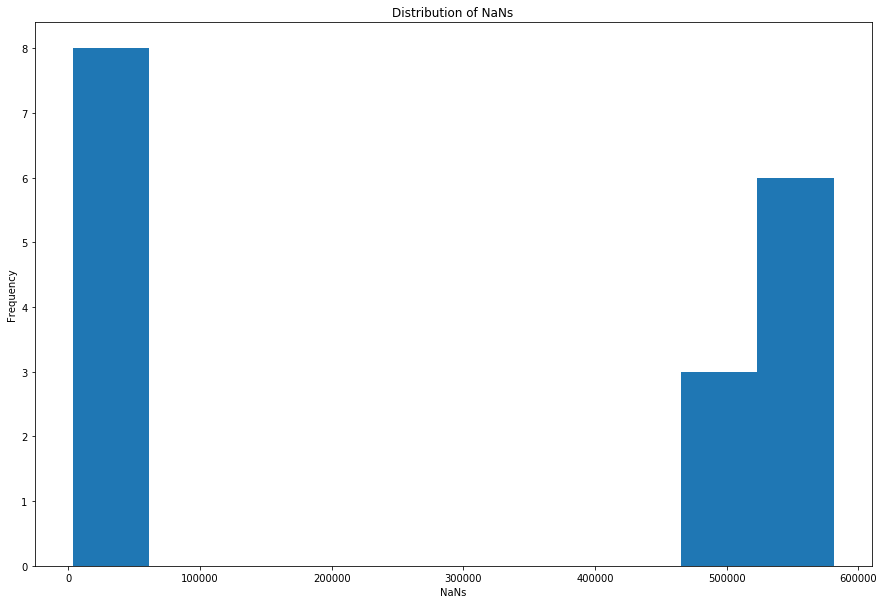

In [19]:
nutrition_facts_thresh_df.isnull().sum().plot(kind='hist', figsize=(15,10))
plt.title('Distribution of NaNs')
plt.xlabel('NaNs')

plt.show()

In [20]:
nutrition_facts_thresh_df.isnull().sum().sort_values()

energy_100g                  3289
proteins_100g                4505
fat_100g                     6407
carbohydrates_100g           6539
sugars_100g                 15533
salt_100g                   17195
sodium_100g                 17236
saturated-fat_100g          30073
fiber_100g                 475780
nutrition-score-fr_100g    502624
nutrition-score-uk_100g    502624
cholesterol_100g           574867
trans-fat_100g             575547
calcium_100g               577579
vitamin-c_100g             578311
iron_100g                  578331
vitamin-a_100g             581242
dtype: int64

### Removing duplicates

In [21]:
nutrition_facts_thresh_df.drop_duplicates(inplace=True)
nutrition_facts_thresh_df.shape

(545334, 17)

In [22]:
print ("We have now {} of samples with {} fields".format(nutrition_facts_thresh_df.shape[0],
                                                         nutrition_facts_thresh_df.shape[1]))

We have now 545334 of samples with 17 fields


This is the maximum that we can do to decrease the number of NaNs in this dataset. All the fields have a balanced number of NaNs that will not be considered in the analysis. Analysing the impact of the ingredients  with nearly the same number of NaNs on the nutrition score will not be biased. 

We decreased the number of fields to have a reasonable and balanced number of NaNs between them. We need now to remove the outliers from the rows of this dataset. 

Let's check the statistics of our data. 

### Some statistics

In [23]:
nutrition_facts_thresh_df.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,5.444370e+05,5.414060e+05,5.312270e+05,99796.000000,101124.000000,541306.000000,5.384300e+05,1.929210e+05,5.433380e+05,5.340690e+05,5.340290e+05,97920.000000,99912.000000,101243.000000,100375.000000,170718.000000,170718.000000
mean,1.224303e+37,2.972528e+01,1.355067e+01,0.087637,0.028124,31.451738,2.306153e+01,2.728224e+02,1.717882e+02,1.540775e+02,6.192468e+01,0.002241,0.020612,0.190057,0.005662,9.579002,9.173104
std,9.033639e+39,1.189092e+04,6.158693e+03,1.751522,0.905369,1168.507645,6.234874e+03,1.159103e+05,1.204814e+05,1.106852e+05,4.427629e+04,0.399670,0.664353,6.058501,0.279986,8.711270,9.122329
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.570000,0.000000,0.000000,-1.786000e+01,-6.700000e+00,-8.000000e+02,0.000000e+00,0.000000e+00,-0.000340,-0.002100,0.000000,-0.000260,-15.000000,-15.000000
25%,4.670000e+02,9.000000e-01,1.000000e-01,0.000000,0.000000,5.000000,1.000000e+00,0.000000e+00,1.500000e+00,9.000000e-02,3.352800e-02,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,1.117000e+03,7.200000e+00,1.900000e+00,0.000000,0.000000,18.820000,4.700000e+00,1.600000e+00,5.800000e+00,5.600000e-01,2.200000e-01,0.000000,0.000000,0.038000,0.001090,10.000000,9.000000
75%,1.686000e+03,2.100000e+01,7.100000e+00,0.000000,0.023000,54.100000,2.200000e+01,3.600000e+00,1.111000e+01,1.318260e+00,5.240000e-01,0.000106,0.004000,0.105000,0.002400,16.000000,17.000000
max,6.665559e+42,8.748748e+06,4.488758e+06,369.000000,141.000000,857855.000000,4.574988e+06,5.089889e+07,8.880858e+07,8.088869e+07,3.235548e+07,100.000000,85.720000,950.000000,50.000000,40.000000,40.000000


Well, It seems that there is no difference between the `nutrition-score-fr_100g` and `nutrition-score-uk_100g`. Let's analyse that. 

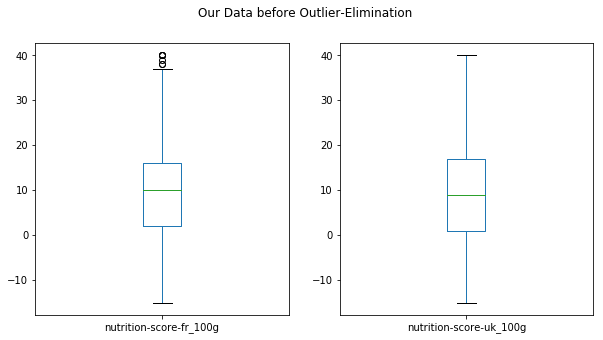

In [24]:
nutrition_facts_thresh_df[['nutrition-score-fr_100g','nutrition-score-uk_100g']].select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data before Outlier-Elimination', figsize=(10,5))

plt.show()

As expected, the two scores has the same distribution except some outliers in the `nutrition-score-fr_100g`.

In [25]:
nutrition_facts_thresh_df.head()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,
0000000000017,1569.0,7.0,3.08,NaN,NaN,70.1,15.0,NaN,7.8,1.40,0.560,NaN,NaN,NaN,NaN,NaN,NaN
0000000000123,88.0,0.0,0.00,NaN,NaN,4.8,0.4,NaN,0.2,2.04,0.816,NaN,NaN,NaN,NaN,NaN,NaN
0000000000178,251.0,3.0,1.00,NaN,NaN,10.0,3.0,NaN,2.0,1.15,0.460,NaN,NaN,NaN,NaN,NaN,NaN
0000000000949,134.0,0.3,0.10,NaN,NaN,5.3,3.9,NaN,0.9,0.42,0.168,NaN,NaN,NaN,NaN,1.0,1.0
0000000000970,540.0,4.9,3.10,NaN,NaN,16.3,16.3,NaN,4.4,0.25,0.100,NaN,NaN,NaN,NaN,NaN,NaN


### What about outliers in the row data?

Let's try to remove all the datapoints that are above or below 3 times the standard deviation assuming that our random varialbes are Gaussians

In [26]:
fields_left=nutrition_facts_thresh_df.columns
for field in fields_left: 
    nutrition_facts_thresh_df=nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df[field]-nutrition_facts_thresh_df
                                                             [field].mean())<=(3*nutrition_facts_thresh_df[field].std())]

In [27]:
print("We have only {} rows left".format(nutrition_facts_thresh_df.shape[0]))

We have only 12795 rows left


We lost huge number of rows by removing the NaNs and the outliers. We are going to see later if this number of samples is enough to have significant results. 

In [28]:
nutrition_facts_thresh_df.head(20)

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,
0000000043595,1255.0,0.00,0.00,0.0,0.000,83.33,66.67,10.0,0.00,0.00000,0.000000,0.000000,0.0000,0.000,0.00000,3.0,3.0
0000020043131,1527.0,1.18,0.00,0.0,0.000,71.76,4.71,2.4,12.94,1.19634,0.478536,0.000000,0.0000,0.071,0.00424,3.0,3.0
0000020045791,1749.0,21.76,5.29,0.0,0.071,51.76,32.94,2.4,5.88,0.67310,0.269240,0.000035,0.0000,0.088,0.00159,17.0,17.0
0000020047825,1623.0,22.35,11.76,0.0,0.000,42.35,15.29,2.4,4.71,0.80772,0.323088,0.000070,0.0282,0.000,0.00169,18.0,18.0
00005487,2243.0,32.14,3.57,0.0,0.000,57.14,0.00,3.6,7.14,0.95250,0.381000,0.000000,0.0214,0.000,0.00129,10.0,10.0
0000609346752,2406.0,40.00,25.00,0.0,0.025,50.00,50.00,0.0,7.50,0.25400,0.101600,0.000000,0.0030,0.250,0.00000,28.0,28.0
0000651511016,59.0,0.00,0.00,0.0,0.000,3.64,1.82,1.8,0.00,0.26670,0.106680,0.000055,0.0082,0.036,0.00033,-5.0,-5.0
0000901000017,1795.0,10.71,0.00,0.0,0.000,78.57,0.00,7.1,7.14,1.63322,0.653288,0.000000,0.0000,0.143,0.00129,7.0,7.0
00014472,1464.0,1.25,0.00,0.0,0.000,75.00,2.50,7.5,15.00,0.00000,0.000000,0.000000,0.0000,0.000,0.00180,-6.0,-6.0


Before analyzing the impact of our variables on the nutrition score, we need to normalize our data by removing the mean and dividng by the standard deviation 

In [29]:
nutrition_facts_thresh_stand_df = nutrition_facts_thresh_df.select_dtypes(include=float).transform(lambda x: (x - x.mean()) / x.std())

We can check now if the mean of our variables is close to zero and the standard deviation is close to 1. 

In [30]:
nutrition_facts_thresh_stand_df.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04,1.279500e+04
mean,1.584421e-17,1.567792e-15,5.141716e-15,-3.941877e-16,7.885108e-15,-6.468761e-15,-9.199016e-15,1.162404e-14,5.142671e-15,2.707248e-16,7.107436e-15,-1.409390e-15,-4.434671e-15,-1.811846e-14,6.798552e-15,-6.919045e-17,-3.108885e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.433584e+00,-7.977315e-01,-6.714250e-01,-4.165188e+00,-4.800327e-01,-1.200783e+00,-7.622760e-01,-8.201468e-01,-1.074755e+00,-7.421260e-01,-7.450374e-01,-1.176025e-01,-2.643747e-01,-6.190795e-01,-6.386431e-01,-2.412502e+00,-2.350678e+00
25%,-9.275508e-01,-7.491377e-01,-6.714250e-01,-9.520929e-02,-4.800327e-01,-8.431127e-01,-6.865068e-01,-8.201468e-01,-7.179560e-01,-6.361222e-01,-6.396161e-01,-1.176025e-01,-2.643747e-01,-6.190795e-01,-6.386431e-01,-8.509169e-01,-8.185029e-01
50%,-1.312353e-01,-4.083742e-01,-4.071605e-01,-9.520929e-02,-4.800327e-01,-3.399356e-01,-4.463571e-01,-3.295372e-01,-2.598259e-01,-1.981067e-01,-2.017120e-01,-1.176025e-01,-2.643747e-01,-2.765815e-01,-2.191427e-01,-7.012443e-02,-1.618565e-01
75%,7.160758e-01,4.778539e-01,3.270834e-01,-9.520929e-02,7.764067e-02,8.314346e-01,3.415136e-01,3.450510e-01,4.073887e-01,2.499092e-01,2.524107e-01,-1.000235e-02,-1.473816e-01,1.982452e-01,3.019209e-01,8.222098e-01,7.136721e-01
max,7.327195e+00,1.942941e+01,9.027241e+00,2.094658e+01,2.426305e+01,2.863652e+00,3.839737e+00,4.085949e+00,3.316729e+00,1.752624e+01,1.122741e+01,1.061030e+02,2.410919e+01,1.245812e+01,1.959452e+01,2.941504e+00,2.902493e+00


In [31]:
nutrition_facts_thresh_stand_df.head()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,
0000000043595,0.207428,-0.797731,-0.671425,-0.095209,-0.480033,2.186111,3.518681,2.246163,-1.074755,-0.742126,-0.745037,-0.117602,-0.264375,-0.619080,-0.638643,-0.516292,-0.490180
0000020043131,0.563089,-0.726056,-0.671425,-0.095209,-0.480033,1.715856,-0.459841,-0.084232,0.772037,0.199907,0.209837,-0.117602,-0.264375,-0.066412,1.233653,-0.516292,-0.490180
0000020045791,0.853372,0.524018,0.165676,-0.095209,1.603905,0.902969,1.352839,-0.084232,-0.235564,-0.212107,-0.207794,-0.073208,-0.264375,0.065916,0.063468,1.045293,1.041995
0000020047825,0.688617,0.559856,1.189504,-0.095209,-0.480033,0.520505,0.219512,-0.084232,-0.402546,-0.106103,-0.100345,-0.029190,1.568517,-0.619080,0.107626,1.156835,1.151436
00005487,1.499316,1.154522,-0.106500,-0.095209,-0.480033,1.121635,-0.762276,0.283725,-0.055737,0.007901,0.015213,-0.117602,1.126543,-0.619080,-0.069006,0.264501,0.275908


Having "-" in the variable names of our dataset will generate a name error when using statsmodel formula for the regression. We change all the "-" caracters in the variable names by "_". 

In [32]:
for field in fields_left: 
    
    nutrition_facts_thresh_stand_df = nutrition_facts_thresh_stand_df.rename(columns={field: field.replace('-','_')})
fields_left=nutrition_facts_thresh_stand_df.columns

Great! our data is now ready for the analysis on the impact of our variables on the nutrition score.

### Variable correlations 

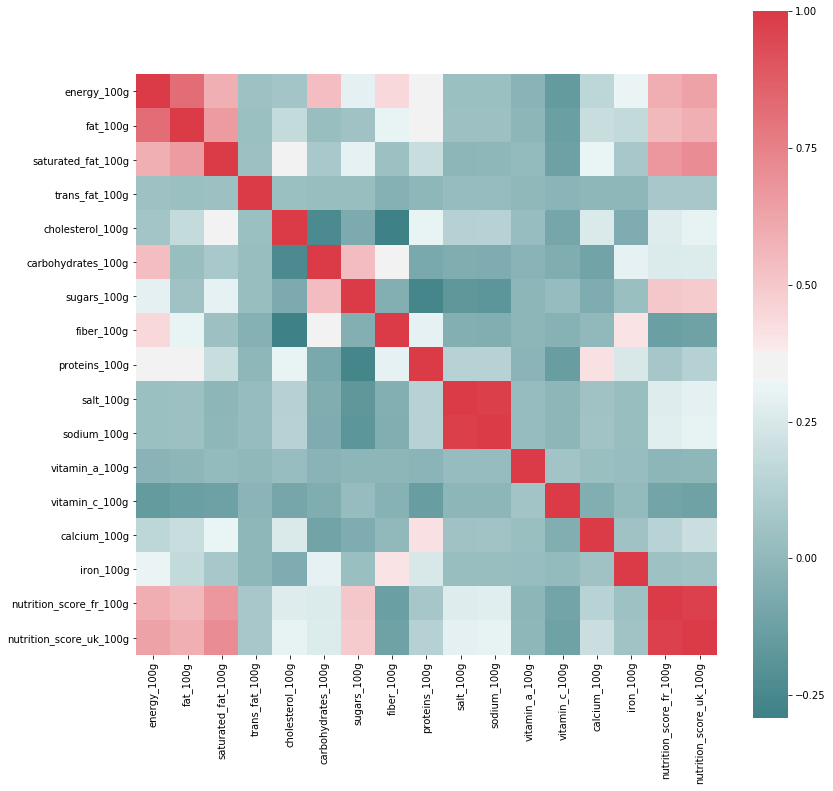

In [33]:
correlation_variables = nutrition_facts_thresh_stand_df.corr(method = "pearson")

f, ax = plt.subplots(figsize=(13, 13))

sns.heatmap(correlation_variables, mask=np.zeros_like(correlation_variables, dtype=np.bool),cmap=sns.diverging_palette(200, 10, as_cmap=True), square=True, ax=ax)

From the plot of correlation above we can confirm first that `nutrition_score_fr_100g` and `nutrition_score_uk_100g` are exactly the same.  
We can see also a  correlation equal to 1 between `sodium_100g` and `salt_100g`. We are going then to drop the column `sodium_100g` to avoid redundancy. 

In [34]:
#We drop sodium column. 
nutrition_facts_thresh_stand_df=nutrition_facts_thresh_stand_df.drop(columns=['sodium_100g'])
fields_left=nutrition_facts_thresh_stand_df.columns

### Regression

Let's prepare our formula for the regression: 

In [35]:
formula_string="nutrition_score_fr_100g ~ "
for field in fields_left[:-2]:
    formula_string=formula_string+field+"+"
formula_string=formula_string[:-1]
formula_string

'nutrition_score_fr_100g ~ energy_100g+fat_100g+saturated_fat_100g+trans_fat_100g+cholesterol_100g+carbohydrates_100g+sugars_100g+fiber_100g+proteins_100g+salt_100g+vitamin_a_100g+vitamin_c_100g+calcium_100g+iron_100g'

In [36]:
nutrition_score_regression = sm.ols(formula= formula_string, data = nutrition_facts_thresh_stand_df)
res = nutrition_score_regression.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     nutrition_score_fr_100g   R-squared:                       0.778
Model:                                 OLS   Adj. R-squared:                  0.778
Method:                      Least Squares   F-statistic:                     3201.
Date:                     Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                             16:36:39   Log-Likelihood:                -8523.4
No. Observations:                    12795   AIC:                         1.708e+04
Df Residuals:                        12780   BIC:                         1.719e+04
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

Analysing the regression results from the coeficents of each ingredient, we can deduce the impact of these ingredients on the the nutrition score.  

#### Positive coef 
* `energy_100g` has the highest positive nutrition score ~ 0.4  
* `sugars_100` has the second highest nutrition score ~ 0.37 
* `salt_100g` has the third highest nutrition score ~ 0.30
* `saturated_fat_100g `has the fourth highest nutrition socre ~ 0,29
#### Negative coef 
* `fiber_100g` has the highest negative nutrition score ~-0.28  

From the french nutrition socre datasheet page 24 we see that the highest the nutrition socre is the lowest the nutritional quality is. We can then deduce that all products with high percentage of energy, sugar,salt and saturated fat all unhealthy and products with high percentage of fiber are healthy. All other ingredients do not have any impact on the nutrition score.  
By analysing the p-value we can deduce that our variables are statiscally significant except the `vitamin_a_100g`.    
The number of samples we have in hand after dropping the outliers and NaNs is enough to have significant resutls.